## Importing libraries

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shap
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, precision_score, recall_score, precision_recall_curve
random.seed(123)

## Loading data

In [31]:
# Loading data
df = pd.read_csv('RJ/dataset_ML_RJ_CC.csv')
df_tplot = df['tplot']
df_cases = df['CASES_100K']
df = df.drop(columns = ['EPI_YEAR','tplot','CASES_100K'])
df['label_2'] = 0 # for most of values, no epidemic yet
df.loc[df['label'] == 'Epi','label_2'] = 1 # epidemic
df.loc[df['label'] == 'High','label_2'] = 1 # epidemic as well
df = df.drop(columns = ['label'])

## Train-test split

In [32]:
df

,EPI_WEEK,rh_max_lag,rh_min_lag,t_min_lag,t_max_lag,LAMBDA_lag,p_total_lag,label_2
0,24,91.811429,66.954286,20.205714,27.544286,0.741729,16.69,0
1,25,96.098571,70.207143,20.414286,27.764286,0.794619,12.53,0
2,26,91.382857,71.561429,19.772857,26.792857,0.956893,6.55,0
3,27,92.267143,69.965714,18.692857,26.058571,1.026744,0.84,0
4,28,95.918571,64.998571,20.512857,24.040000,1.018160,9.93,0
...,...,...,...,...,...,...,...,...
493,47,84.472857,71.401429,19.927143,27.330000,0.617460,0.15,0
494,48,85.347143,64.668571,18.378571,25.234286,0.534591,8.64,0
495,49,88.964286,65.974286,20.152857,27.360000,-0.129386,1.09,0
496,50,92.134286,72.792857,20.258571,26.128571,0.240050,13.33,0


In [33]:
df['label_2'].value_counts()

0    486
1     12
Name: label_2, dtype: int64

In [34]:
X = df.iloc[:,0:7]
y = df.iloc[:,7]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.6, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test, test_size = 0.5, random_state = 0)

In [35]:
print('Train: ', y_train.shape)
print('Test: ', y_test.shape)
print('Validation: ', y_val.shape)

Train:  (199,)
Test:  (149,)
Validation:  (150,)


## Doing hyperparameter tuning for XGBoost Classifier

In [ ]:
hyperparameter_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [ 0.001, 0.005,0.01, 0.02, 0.05, 0.1],
    'min_child_weight': [1, 2, 5, 10, 50, 100, 150, 200]
    }

clx = XGBClassifier(random_state = 0, nthread = 8)
grid = GridSearchCV(clx, hyperparameter_grid, scoring="roc_auc")
grid.fit(X_train, y_train)

In [8]:
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.9690283400809717 with param: {'learning_rate': 0.001, 'max_depth': None, 'min_child_weight': 5, 'n_estimators': 50}


### Tuning the threshold

In [9]:
y_val_pred = grid.predict(X_val)
y_val_proba = grid.predict_proba(X_val)[:,1]

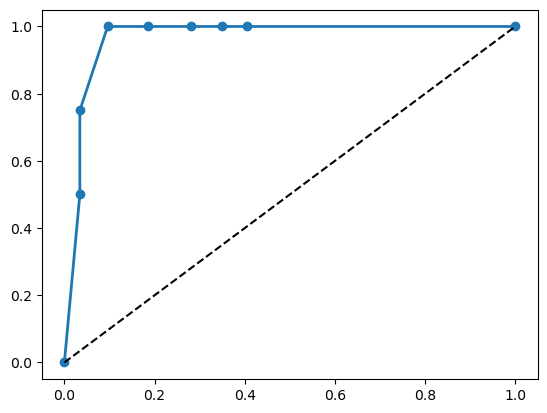

In [10]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba, pos_label = 1)
plt.plot(fpr, tpr, '-o', linewidth=2)
plt.plot([0,1], [0,1], 'k--' )

In [11]:
print(fpr)
print(tpr)
print(thresholds)

[0.         0.03424658 0.03424658 0.09589041 0.18493151 0.28082192
 0.34931507 0.40410959 1.        ]
[0.   0.5  0.75 1.   1.   1.   1.   1.   1.  ]
[1.1294212  0.1294212  0.12792826 0.12771627 0.12729305 0.12624013
 0.1258211  0.12561211 0.12415684]


In [12]:
thr_opt = thresholds[3]

### Setting threshold and evaluating on test

In [13]:
y_test_pred = grid.predict(X_test)
y_test_proba = grid.predict_proba(X_test)[:,1]
y_test_final = y_test_proba.copy()
y_test_final[y_test_proba >= thr_opt] = 1
y_test_final[y_test_proba < thr_opt] = 0
print(confusion_matrix(y_test, y_test_final))
print('Test Metrics')
print('False Positive Rate: ', 34/(34 + 104))
print('True Positive Rate: ', 12/(12 + 0))

[[132  14]
 [  0   3]]
Test Metrics
False Positive Rate:  0.2463768115942029
True Positive Rate:  1.0


In [14]:
y_train_pred = grid.predict(X_train)
y_train_proba = grid.predict_proba(X_train)[:,1]
y_train_final = y_train_proba.copy()
y_train_final[y_train_proba >= thr_opt] = 1
y_train_final[y_train_proba < thr_opt] = 0
print(confusion_matrix(y_train, y_train_final))
print('Train Metrics')
print('False Positive Rate: ', 18/(18 + 166))
print('True Positive Rate: ', 16/(16))

[[176  18]
 [  0   5]]
Train Metrics
False Positive Rate:  0.09782608695652174
True Positive Rate:  1.0


In [15]:
y_val_pred = grid.predict(X_val)
y_val_proba = grid.predict_proba(X_val)[:,1]
y_val_final = y_val_proba.copy()
y_val_final[y_val_proba >= thr_opt] = 1
y_val_final[y_val_proba < thr_opt] = 0
print(confusion_matrix(y_val, y_val_final))
print('Validation Metrics')
print('False Positive Rate: ', 18/(18 + 120))
print('True Positive Rate: ', 12/(12 + 0))

[[132  14]
 [  0   4]]
Validation Metrics
False Positive Rate:  0.13043478260869565
True Positive Rate:  1.0


### Embedded Feature Importance 

Text(0.5, 0, 'Feature Importance')

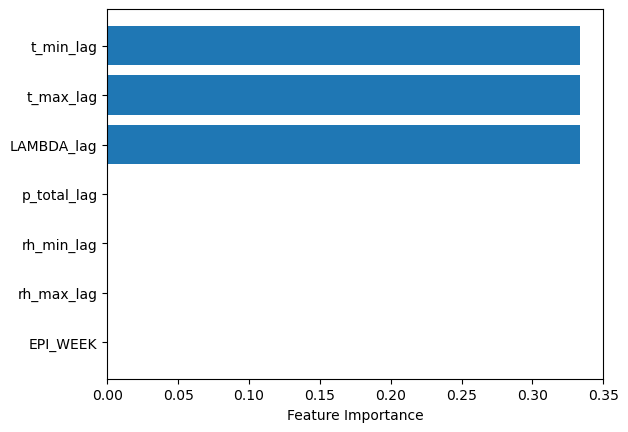

In [16]:
sorted_params = grid.best_estimator_.feature_importances_.argsort()
plt.barh(df.columns[sorted_params], grid.best_estimator_.feature_importances_[sorted_params])
plt.xlabel('Feature Importance')

### SHAP Values

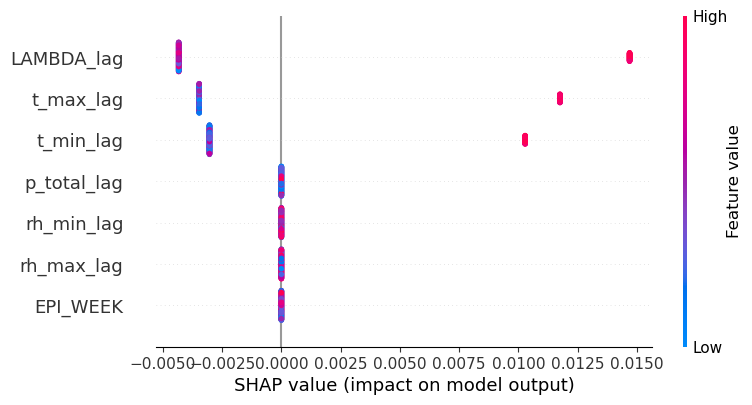

In [17]:
explainer = shap.Explainer(grid.best_estimator_)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

## Visualizing predictions - where do we fail?

In [18]:
y_pred_proba = grid.predict_proba(X)[:,1]
y_pred_final = y_pred_proba.copy()
y_pred_final[y_pred_proba >= thr_opt] = 1
y_pred_final[y_pred_proba < thr_opt] = 0

In [19]:
confusion_matrix(y, y_pred_final)

array([[440,  46],
       [  0,  12]], dtype=int64)

In [20]:
print('True positive rate: ', 40/(40 + 0))
print('False positive rate: ', 70/(70 + 390))

True positive rate:  1.0
False positive rate:  0.15217391304347827


### False negatives, which is what worries us the most

In [21]:
fn = ((y == 1) & (y_pred_final == 0))
sem_fn = X[fn]

In [22]:
sem_fn

,EPI_WEEK,rh_max_lag,rh_min_lag,t_min_lag,t_max_lag,LAMBDA_lag,p_total_lag


### False positives

In [23]:
fp = ((y == 0) & (y_pred_final == 1))
sem_fp = X[fp]

In [24]:
sem_fp['EPI_WEEK'].value_counts()

18    5
17    5
6     4
16    4
15    3
5     3
22    2
7     2
8     2
14    2
4     2
20    2
21    1
52    1
26    1
51    1
1     1
19    1
13    1
12    1
11    1
23    1
Name: EPI_WEEK, dtype: int64

### Classifying and labeling each situation

In [25]:
fn = ((y == 1) & (y_pred_final == 0))
fp = ((y == 0) & (y_pred_final == 1))
tn = ((y == 0) & (y_pred_final == 0))
tp = ((y == 1) & (y_pred_final == 1))

In [26]:
Z = X.copy()
Z['label'] = 0

In [27]:
Z.loc[fn,'label'] = 'FN'
Z.loc[fp,'label'] = 'FP'
Z.loc[tn,'label'] = 'TN'
Z.loc[tp, 'label'] = 'TP'

In [28]:
Z['tplot'] = np.array(df_tplot)
Z['CASES_100K'] = np.array(df_cases)

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


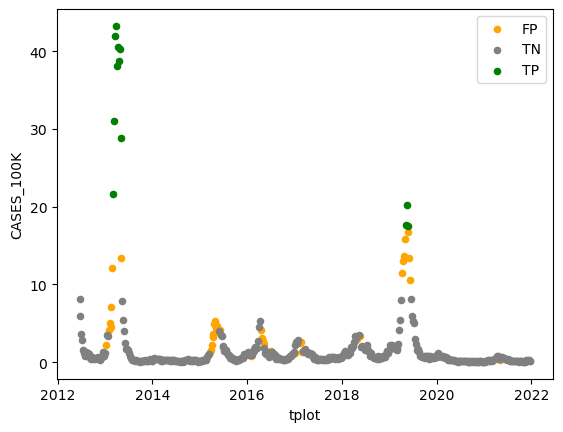

In [29]:
fig, ax = plt.subplots()

colors = {'TP':'green', 'TN':'gray', 'FP':'orange', 'FN':'red'}

grouped = Z.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='tplot', y='CASES_100K', label=key, color=colors[key])

plt.show()